# Step 1: Load, normalise, and filter LLM data
### This turns it into the dataframe llm_data

In [24]:
import pandas as pd
import sqlite3
import yaml
from datetime import datetime

# Load configuration
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Connect to the SQLite database
conn = sqlite3.connect(config['db_path'])

# Read data from the 'events' table
query = "SELECT * FROM events"
llm_data = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Normalize the date column
llm_data['normalized_date'] = pd.to_datetime(llm_data['date'], errors='coerce')

# Remove rows with invalid dates
llm_data = llm_data[llm_data['normalized_date'].notna()]

# Normalize the 'name' field
llm_data['normalized_name'] = llm_data['name'].str.strip().str.lower()

# Identify and remove duplicates, understood as having the same name and date
duplicates = llm_data.duplicated(subset=['normalized_date', 'normalized_name'], keep=False)
unique_data = llm_data[~duplicates]
duplicate_data = llm_data[duplicates]

# Combine discarded entries
combined_discards = pd.concat([duplicate_data, llm_data[llm_data['normalized_date'].isna()]])

# Save the discarded entries
today_date = pd.Timestamp.now().strftime('%Y-%m-%d')
combined_discards.to_json(f'Cleaning/{today_date}_rejected_step_1.json', orient='records', force_ascii=False)

# Get the columns to compare from the config
columns_to_compare = config['columns_to_compare']
llm_data = unique_data[columns_to_compare].copy()

# Normalize text in all columns
def normalize_text(text):
    if pd.isna(text) or str(text).strip().lower() == "unknown":
        return ""
    return ' '.join(str(text).lower().split())

# Apply normalization to all text columns
text_columns = llm_data.select_dtypes(include=['object']).columns
for col in text_columns:
    llm_data[col] = llm_data[col].apply(normalize_text)

llm_data = llm_data.applymap(normalize_text)

# Display the result
display(llm_data.head(5))

/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_78698/2531528880.py:21: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  llm_data['normalized_date'] = pd.to_datetime(llm_data['date'], errors='coerce')
/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_78698/2531528880.py:56: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  llm_data = llm_data.applymap(normalize_text)


,normalized_date,name,venue
0,1908-02-15 00:00:00,"gästspel av fru matilda jungstedt, boccaccio",oscarsteatern
1,1908-02-17 00:00:00,fru inna lundberg populär sång-afton,vetenskapsakademiens hörsal
2,1908-02-15 00:00:00,middags-konsert,berns
3,1908-02-15 00:00:00,kalle- och afton-konsert,arbetareinstitutet
4,1908-02-16 00:00:00,folk-konsert,nan


# Import Human Data

In [25]:
import pandas as pd
from datetime import datetime
import yaml

# Load configuration
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Load data
human_data = pd.read_excel(config['Stockholm_Concert_Database_Path'])

# Make all column names lowercase
human_data.columns = [col.lower() for col in human_data.columns]

# Rename the columns in the human data to match the events table using the config
human_data = human_data.rename(columns=config['column_mapping'])

# Function to convert date objects in the human data
def convert_human_dates(date_obj):
    if isinstance(date_obj, str):
        try:
            date = datetime.strptime(date_obj, "%Y-%m-%d")
        except ValueError:
            return None
    elif isinstance(date_obj, pd.Timestamp):
        date = date_obj.to_pydatetime()
    else:
        return None
    return date.strftime("%Y-%m-%d %H:%M:%S")

# Normalize the date column by applying the convert_human_dates function
human_data['normalized_date'] = human_data['date'].apply(convert_human_dates)

# Drop the original 'date' column
human_data = human_data.drop('date', axis=1)

# Remove rows with invalid dates
human_data = human_data[human_data['normalized_date'].notna()]

# Apply normalization to all text columns
text_columns = human_data.select_dtypes(include=['object']).columns
for col in text_columns:
    human_data[col] = human_data[col].apply(normalize_text)


# Display the result
display(human_data.head(10))


,konsert_id,name,venue,konsert_biljettpris,summaförannons/program,summaförrecension,summaförantalförkonsert_verk_id,organiser,konserttyp_namn,månad,år,dag,månadnr,lokal_namn_eng,konserttyp_namn_eng,producer,normalized_date
0,2528,brüssel-kvartetten beethovenafton,kungliga musikaliska akademiens lokal,,NaN,NaN,NaN,brüssel-stråkkvartetten,kammarmusikkonsert,january,1908,thursday,1,NaN,chamber music concert,brüssel-stråkkvartetten - brussels string quartet,1908-01-02 00:00:00
1,2509,1:sta säsångskonsert: nordisk afton,hotel continentals festsal,"2kr (numrerade platser), 1:50kre och 1kr",2.0,NaN,14.0,"gellin, eduard",konsert,january,1908,sunday,1,NaN,concert,"gellin, eduard",1908-01-05 00:00:00
2,2521,afskedskonsert,immanuelskyrkan,,NaN,2.0,NaN,"bohlin, carl. direktör",kyrkokonsert,january,1908,sunday,1,NaN,church concert,"bohlin, carl. director",1908-01-05 00:00:00
3,2516,folk-konsert,"arbetare-institutet, klara norra kyrkogata 8",,2.0,NaN,5.0,,folkkonsert,january,1908,sunday,1,NaN,folk concert,,1908-01-05 00:00:00
4,2515,populärkonsert,vetenskapsakademiens hörsal,,NaN,NaN,NaN,"hansson, axel",populärkonsert,january,1908,sunday,1,NaN,popular concert,"hansson, axel",1908-01-05 00:00:00
5,2510,2:a populära symfoni-matinéen,berns salong,"1kr till salongen, 1:50kr till läktaren",NaN,2.0,NaN,berns,konsert,january,1908,monday,1,NaN,concert,berns,1908-01-06 00:00:00
6,2511,jul-fest med bal,grand restaurant nationals stora salong,"1:25kr herre, 1kr da, 50öre barn",NaN,NaN,NaN,lj. b.,bal,january,1908,monday,1,NaN,ball,lj. b.,1908-01-06 00:00:00
7,2517,populär soaré,vetenskapsakademiens hörsal,"1kr reserverad plats, 75öre övriga platser",1.0,NaN,9.0,"dahlberg, erik",populärkonsert,january,1908,monday,1,NaN,popular concert,"dahlberg, erik",1908-01-06 00:00:00
8,2519,populär soaré,"arbetare-institutet, klara norra kyrkogata 8","1kr reserverad plats, 75öre, 50öre",NaN,NaN,NaN,arbetareinstitutet,populärkonsert,january,1908,monday,1,NaN,popular concert,arbetareinstitutet - workers' institute,1908-01-06 00:00:00
9,2512,2:a kammarmusikkonsert: brahmsafton,vetenskapsakademiens hörsal,"3kr numrerade, 2:50kr onumrerade",3.0,2.0,3.0,aulinkvartetten,kammarmusikkonsert,january,1908,tuesday,1,NaN,chamber music concert,aulinkvartetten - aulin quartet,1908-01-07 00:00:00


# Cleaning the two datasets for comparison

In [26]:
from IPython.display import display

import pandas as pd
import numpy as np

# Ensure both DataFrames only have the columns to compare and normalized_date
required_columns = columns_to_compare + ['normalized_date']
assert all(col in llm_data.columns for col in required_columns), "Missing required columns in llm_data"
assert all(col in human_data.columns for col in required_columns), "Missing required columns in human_data"

llm_data = llm_data[required_columns]
human_data = human_data[required_columns]

# Remove duplicate columns if they exist
llm_data = llm_data.loc[:, ~llm_data.columns.duplicated()]
human_data = human_data.loc[:, ~human_data.columns.duplicated()]

# Ensure the 'normalized_date' column is 1-dimensional and properly formatted
llm_data['normalized_date'] = pd.to_datetime(llm_data['normalized_date'], errors='coerce')
human_data['normalized_date'] = pd.to_datetime(human_data['normalized_date'], errors='coerce')

# Drop rows with invalid 'normalized_date' values
human_data = human_data.dropna(subset=['normalized_date'])

display(llm_data)
display(human_data)


,normalized_date,name,venue
0,1908-02-15,"gästspel av fru matilda jungstedt, boccaccio",oscarsteatern
1,1908-02-17,fru inna lundberg populär sång-afton,vetenskapsakademiens hörsal
2,1908-02-15,middags-konsert,berns
3,1908-02-15,kalle- och afton-konsert,arbetareinstitutet
4,1908-02-16,folk-konsert,nan
...,...,...,...
362,1908-05-09,fru hwasser-engelbrekts soaré,folkets hus teater
365,1908-02-02,templarnas festkonsert,gustaf vasakyrkan
366,1908-02-01,den förtrollade kattens,kungliga operan/kungliga teatern
371,1908-05-17,coppelia,kungliga operan/kungliga teatern


,normalized_date,name,venue
0,1908-01-02,brüssel-kvartetten beethovenafton,kungliga musikaliska akademiens lokal
1,1908-01-05,1:sta säsångskonsert: nordisk afton,hotel continentals festsal
2,1908-01-05,afskedskonsert,immanuelskyrkan
3,1908-01-05,folk-konsert,"arbetare-institutet, klara norra kyrkogata 8"
4,1908-01-05,populärkonsert,vetenskapsakademiens hörsal
...,...,...,...
509,1908-12-26,familje-soiré,vetenskapsakademiens hörsal
510,1908-12-26,populär soaré,"arbetare-institutet, klara norra kyrkogata 8"
511,1908-12-27,populär soaré,"arbetare-institutet, klara norra kyrkogata 8"
512,1908-12-31,nyårsvaka å runan,


# Human_Data: Comparing every row of human_data to LLM to find best match

In [27]:
from fuzzywuzzy import fuzz
# Function to compute the maximum fuzzy match score and index for a given row against a group of rows
def compute_fuzzy_match_with_date(row1_str, date_group, group_indices):
    max_score = 0
    best_index = None
    for idx, row2_str in zip(group_indices, date_group):
        score = fuzz.token_set_ratio(row1_str, row2_str)
        if score > max_score:
            max_score = score
            best_index = idx
    return (max_score if max_score > 0 else np.nan, best_index)

# Preprocess llm_data to group by 'normalized_date'
date_groups = llm_data.groupby('normalized_date').apply(
    lambda df: (
        [' '.join(map(str, [row[col] for col in columns_to_compare if col in row])) for _, row in df.iterrows()],
        df.index.tolist()
    )
)

# Compute match scores and best match indices for each row in human_data
human_data['match_score'], human_data['best_match_index'] = zip(*human_data.apply(
    lambda row: compute_fuzzy_match_with_date(
        ' '.join(map(str, [row[col] for col in columns_to_compare if col in row])),
        *date_groups.get(row['normalized_date'], ([], []))
    ),
    axis=1
))

# Sort human_data by 'match_score' in descending order
sorted_human_data = human_data.sort_values(by='match_score', ascending=False)

# Display the relevalt columns
display(sorted_human_data[['match_score', 'best_match_index']])

/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_78698/513110085.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_groups = llm_data.groupby('normalized_date').apply(


,match_score,best_match_index
234,100.0,270.0
194,100.0,56.0
25,100.0,63.0
181,100.0,316.0
59,100.0,50.0
...,...,...
509,NaN,NaN
510,NaN,NaN
511,NaN,NaN
512,NaN,NaN


# Statistics for the Human_data, detailing how close a match in the LLM data has been found

#### Best score so far is 69.75 achieved by comparing 'normalized_date', 'normalized_konsert_namn', 'lokal_namn', so if it's lower than that then you better have a good reason

Average of 'match_score': 65.47089947089947
25th Percentile of 'match_score': 54.0
Median (50th Percentile) of 'match_score': 64.0
75th Percentile of 'match_score': 80.0
Median of 'match' score': 64.0
Standard Deviation of 'match_score': 16.68307365346908


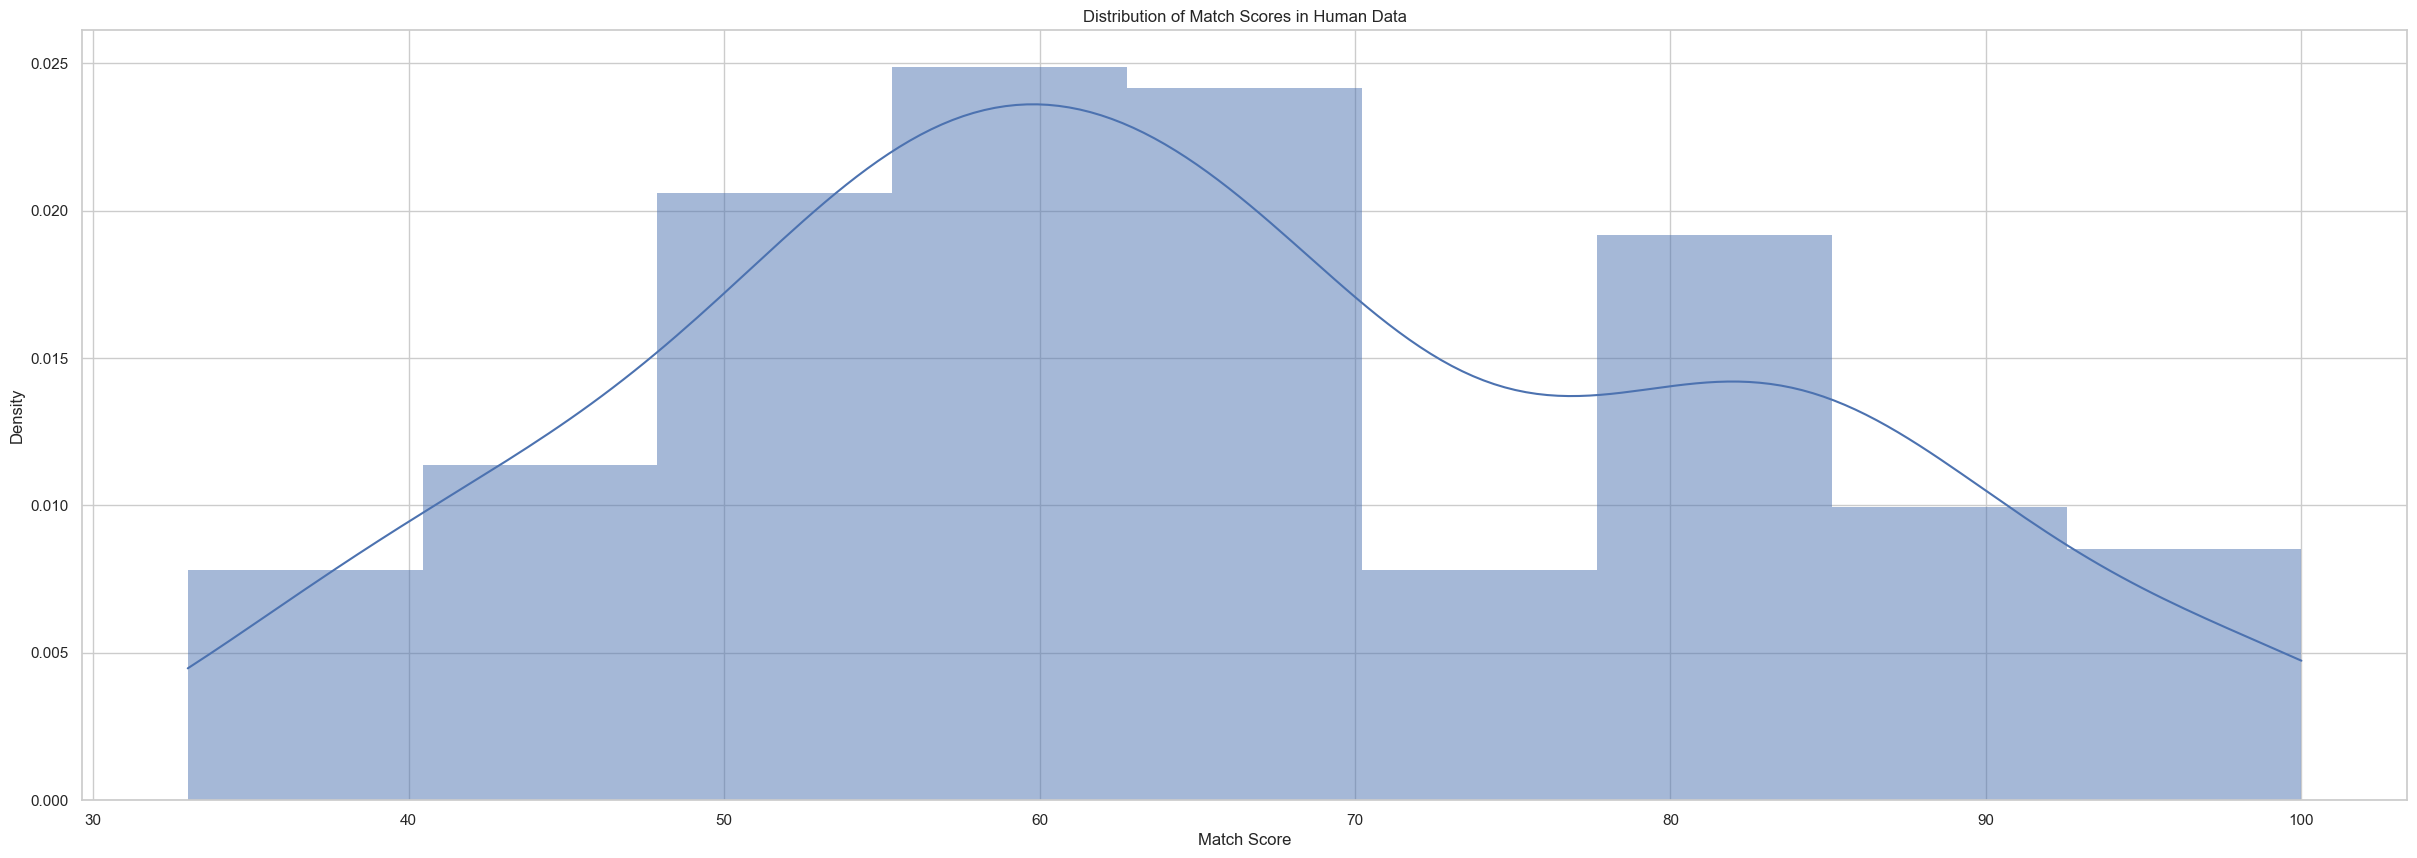

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the standard deviation of the 'match_score' column in human_data
std_deviation = human_data['match_score'].std()

# Calculate the average of the 'match_score' column in human_data
average_match_score = human_data['match_score'].mean()

# Print the average match score
print("Average of 'match_score':", average_match_score)

# Calculate specific percentiles of the 'match_score' column in human_data
percentile_25 = human_data['match_score'].quantile(0.25)
percentile_50 = human_data['match_score'].quantile(0.50)  # This is the median
percentile_75 = human_data['match_score'].quantile(0.75)

# Print the percentile values
print("25th Percentile of 'match_score':", percentile_25)
print("Median (50th Percentile) of 'match_score':", percentile_50)
print("75th Percentile of 'match_score':", percentile_75)

# Calculate the median of the 'match_score' column in human_data
median_match_score = human_data['match_score'].median()

# Print the median match score
print("Median of 'match' score':", median_match_score)

# Print the standard deviation
print("Standard Deviation of 'match_score':", std_deviation)

# Setting the style and color palette of the plot
sns.set(style="whitegrid")

# Creating the density plot for match_score distribution in human_data
plt.figure(figsize=(30, 10))
sns.histplot(human_data['match_score'], kde=True, stat="density", linewidth=0)

# Adding titles and labels
plt.title('Distribution of Match Scores in Human Data')
plt.xlabel('Match Score')
plt.ylabel('Density')

# Display the plot
plt.show()


# Experimenting with a different comparison algo for better results

In [22]:
import pandas as pd
from fuzzywuzzy import fuzz

import pandas as pd
from fuzzywuzzy import fuzz

def compare_rows(row1, row2):
    scores = []
    for col in row1.index:
        val1 = str(row1[col])
        val2 = str(row2[col])
        
        # Handle missing values
        if val1 == 'nan':
            val1 = 'MISSING'
        if val2 == 'nan':
            val2 = 'MISSING'
        
        # Compare only the date component
        if col == 'date_column':
            date1 = pd.to_datetime(val1).date()
            date2 = pd.to_datetime(val2).date()
            date_score = fuzz.ratio(str(date1), str(date2))
            scores.append(date_score)
        else:
            scores.append(fuzz.ratio(val1, val2))
    
    return sum(scores) / len(scores)

def compare_dataframes(df1, df2):
    matches = []
    for _, row1 in df1.iterrows():
        max_score = 0
        best_match = None
        for _, row2 in df2.iterrows():
            score = compare_rows(row1, row2)
            if score > max_score:
                max_score = score
                best_match = row2
        matches.append((row1, best_match, max_score))
    return matches


# Assuming llm_data and human_data are already defined and loaded

matches = compare_dataframes(llm_data, human_data)

for llm_row, human_row, score in matches:
    print(f"LLM Row: {llm_row.to_dict()}")
    print(f"Human Row: {human_row.to_dict()}")
    print(f"Match Score: {score}")
    print("-" * 50)



LLM Row: {'normalized_date': Timestamp('1908-02-15 00:00:00'), 'name': 'gästspel av fru matilda jungstedt, boccaccio', 'venue': 'oscarsteatern'}
Human Row: {'normalized_date': Timestamp('1908-04-19 00:00:00'), 'name': 'musikalisk soaré', 'venue': 'oscarsteatern', 'match_score': 59.0, 'best_match_index': 498.0}
Match Score: 68.66666666666667
--------------------------------------------------
LLM Row: {'normalized_date': Timestamp('1908-02-17 00:00:00'), 'name': 'fru inna lundberg populär sång-afton', 'venue': 'vetenskapsakademiens hörsal'}
Human Row: {'normalized_date': Timestamp('1908-02-21 00:00:00'), 'name': 'populär sångafton', 'venue': 'vetenskapsakademiens hörsal', 'match_score': 41.0, 'best_match_index': 225.0}
Match Score: 86.33333333333333
--------------------------------------------------
LLM Row: {'normalized_date': Timestamp('1908-02-15 00:00:00'), 'name': 'middags-konsert', 'venue': 'berns'}
Human Row: {'normalized_date': Timestamp('1908-02-13 00:00:00'), 'name': 'familjeaf

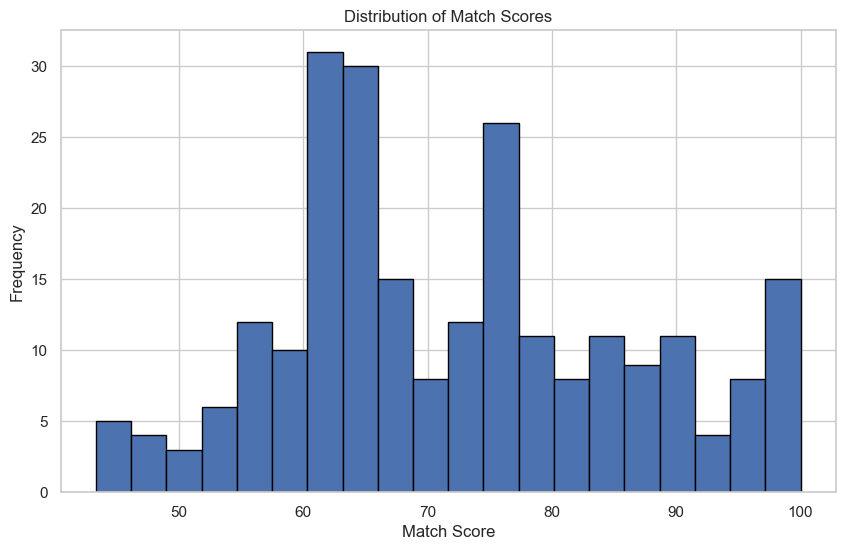

In [23]:
import matplotlib.pyplot as plt

# Assuming matches is the list of tuples returned by compare_dataframes
scores = [score for _, _, score in matches]

plt.figure(figsize=(10, 6))
plt.hist(scores, bins=20, edgecolor='black')
plt.title('Distribution of Match Scores')
plt.xlabel('Match Score')
plt.ylabel('Frequency')
plt.show()
